# Using ESMF LocStream objects

(contributed by [Raphael Dussin](https://github.com/raphaeldussin))

ESMF [LocStream](http://www.earthsystemmodeling.org/esmf_releases/last_built/esmpy_doc/html/locstream.html?highlight=locstream) objects describe a list of geographical points, represented by 1-dimensional arrays of lat/lon coordinates. It is useful for remapping gridded data (e.g. from model output) to/from observation locations, or creating model boundary conditions.

In [1]:
import xarray as xr
import xesmf as xe

## Remapping from a grid to a LocStream

Let's open a gridded dataset (for example the xarray air temperature dataset):

In [2]:
airtemps = xr.tutorial.open_dataset('air_temperature')

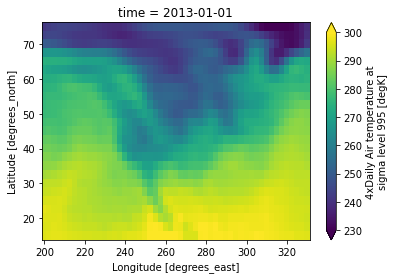

In [3]:
airtemps['air'].isel(time=0).plot(vmin=230, vmax=300)

Now let's define a list of geographical points (1-D arrays). The name of the dimension used for the LocStream is not important.

In [4]:
ds_locs = xr.Dataset()
ds_locs['lon'] = xr.DataArray(data=[220,230,240,250,260,270], dims=('location'))
ds_locs['lat'] = xr.DataArray(data=[20,30,40,50,60,70], dims=('locations'))

Creating a `Regridder` for LocStream object can be done by setting `locstream_out` or `locstream_in` (or both) to `True`. Some algorithms like `conservative` are not allowed with locstream input/output. See [this comment](https://github.com/JiaweiZhuang/xESMF/pull/81#issuecomment-588462933) for more discussions.

With `locstream_out=True`, the regridder behaves like [Xarray's advanced indexing](http://xarray.pydata.org/en/stable/interpolation.html#advanced-interpolation).

In [5]:
regridder = xe.Regridder(airtemps, ds_locs, 'bilinear', locstream_out=True)

Overwrite existing file: bilinear_25x53_1x6.nc 
 You can set reuse_weights=True to save computing time.


In [6]:
airtemps_locs = regridder(airtemps)

using dimensions ('lat', 'lon') from data variable air as the horizontal dimensions for this dataset.


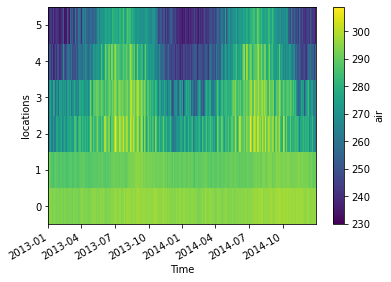

In [7]:
airtemps_locs['air'].plot(x='time')

## Remapping from LocStream to grid

The opposite transformation is also possible, but only available methods are `nearest_s2d` and `nearest_d2s`.

In [8]:
regridder_back_s2d = xe.Regridder(airtemps_locs, airtemps, 'nearest_s2d', locstream_in=True)

Overwrite existing file: nearest_s2d_1x6_25x53.nc 
 You can set reuse_weights=True to save computing time.


In [9]:
airtemps_locs

<xarray.Dataset>
Dimensions:  (locations: 6, time: 2920)
Coordinates:
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
    lon      (locations) int64 220 230 240 250 260 270
    lat      (locations) int64 20 30 40 50 60 70
Dimensions without coordinates: locations
Data variables:
    air      (time, locations) float64 292.8 288.9 268.1 ... 268.4 255.5 236.8
Attributes:
    regrid_method:  bilinear

In [10]:
airtemps_gridded2 = regridder_back_s2d(airtemps_locs)

using dimensions ('locations',) from data variable air as the horizontal dimensions for this dataset.


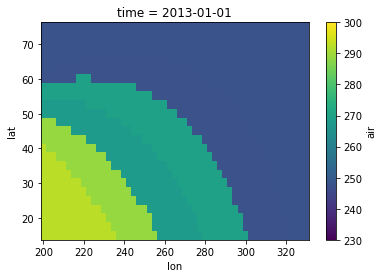

In [11]:
airtemps_gridded2['air'].isel(time=0).plot(vmin=230, vmax=300)

Since we drastically undersampled the original dataset, the reconstruction is very different
from the original. The other nearest-neighbor option (d2s) will only map one destination grid point per LocStream point: 

In [12]:
regrid_back_d2s = xe.Regridder(airtemps_locs, airtemps, 'nearest_d2s', locstream_in=True)

Overwrite existing file: nearest_d2s_1x6_25x53.nc 
 You can set reuse_weights=True to save computing time.


In [13]:
airtemps_gridded3 = regrid_back_d2s(airtemps_locs)

using dimensions ('locations',) from data variable air as the horizontal dimensions for this dataset.


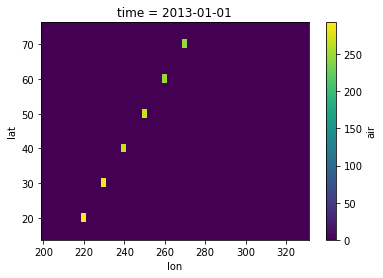

In [14]:
airtemps_gridded3['air'].isel(time=0).plot()

## LocStream to LocStream

It is also possible to remap from one LocStream to another, again only nearest neighbor methods are available.

In [15]:
ds_locs2 = xr.Dataset()
ds_locs2['lon'] = xr.DataArray(data=[225,235,245,255,265,275], dims=('location'))
ds_locs2['lat'] = xr.DataArray(data=[20,30,40,50,60,70], dims=('locations'))

In [16]:
regrid_l2l = xe.Regridder(ds_locs, ds_locs2, 'nearest_s2d',
                          locstream_in=True, locstream_out=True)

Overwrite existing file: nearest_s2d_1x6_1x6.nc 
 You can set reuse_weights=True to save computing time.


In [17]:
airtemps_locs2 = regrid_l2l(airtemps_locs)

using dimensions ('locations',) from data variable air as the horizontal dimensions for this dataset.


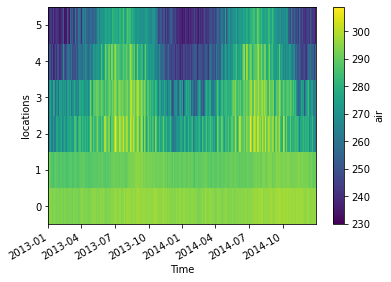

In [18]:
airtemps_locs2['air'].plot(x='time')